# Exponential decay

\begin{equation} \label{solve_expdec} \tag{1}
  g'(x) = -\gamma g(x)
\end{equation}

\begin{equation}
  g(x) = g_0 \exp\left(-\gamma x\right)
\\
  g_0 = 10~~,~~\gamma = 2
\label{_auto2} \tag{2}
\end{equation}

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
torch.manual_seed(15)


def g_analytic(t, gamma=2, g0=10):
    return g0 * np.exp(-gamma * t)

In [3]:
class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.ELU
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [13]:
torch.tensor(0.).view(-1, 1)

tensor([[0.]])

In [14]:
torch.tensor(0.)

tensor(0.)

In [15]:
torch.linspace(0, 1, 30)

tensor([0.0000, 0.0345, 0.0690, 0.1034, 0.1379, 0.1724, 0.2069, 0.2414, 0.2759,
        0.3103, 0.3448, 0.3793, 0.4138, 0.4483, 0.4828, 0.5172, 0.5517, 0.5862,
        0.6207, 0.6552, 0.6897, 0.7241, 0.7586, 0.7931, 0.8276, 0.8621, 0.8966,
        0.9310, 0.9655, 1.0000])

In [16]:
torch.linspace(0, 1, 30).view(-1, 1)

tensor([[0.0000],
        [0.0345],
        [0.0690],
        [0.1034],
        [0.1379],
        [0.1724],
        [0.2069],
        [0.2414],
        [0.2759],
        [0.3103],
        [0.3448],
        [0.3793],
        [0.4138],
        [0.4483],
        [0.4828],
        [0.5172],
        [0.5517],
        [0.5862],
        [0.6207],
        [0.6552],
        [0.6897],
        [0.7241],
        [0.7586],
        [0.7931],
        [0.8276],
        [0.8621],
        [0.8966],
        [0.9310],
        [0.9655],
        [1.0000]])

In [4]:
model = FCN(1, 1, 32, 3)
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, 1, 300).view(-1, 1)
g0 = 10
gamma = 2
g_exact = g_analytic(t_test, gamma, g0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_iter = 15001

\begin{equation}
\mathcal{L}(\theta)= (N\!N(0;\theta) - 10)^2 + \frac{\lambda}{N} \sum^{N}_{i} \left( \left[ N\!N'(t_{i};\theta + \gamma N\!N(t_{i};\theta) \right] \right)^2
\end{equation}

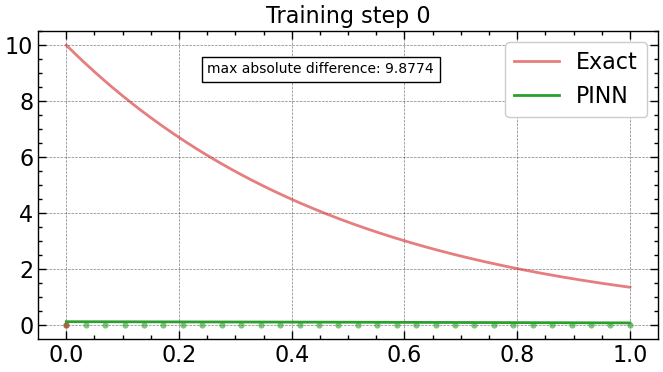

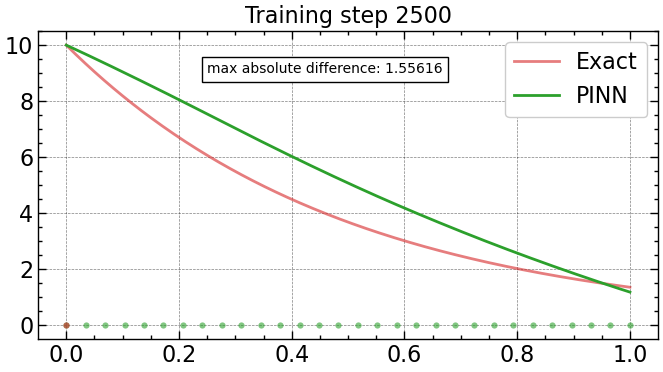

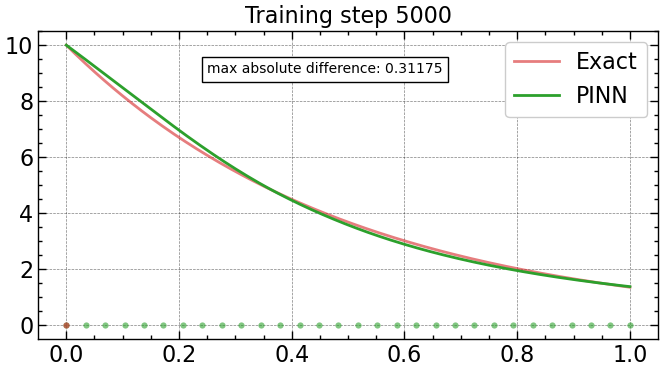

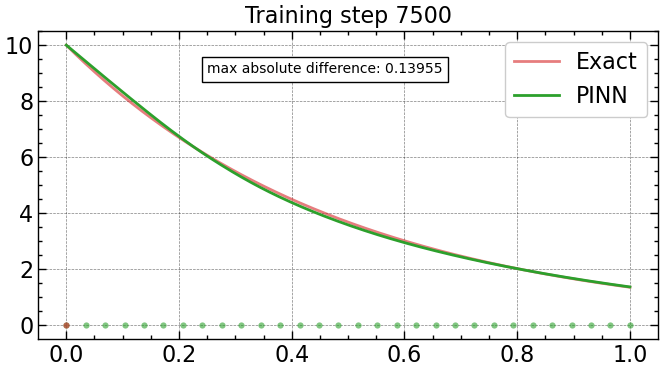

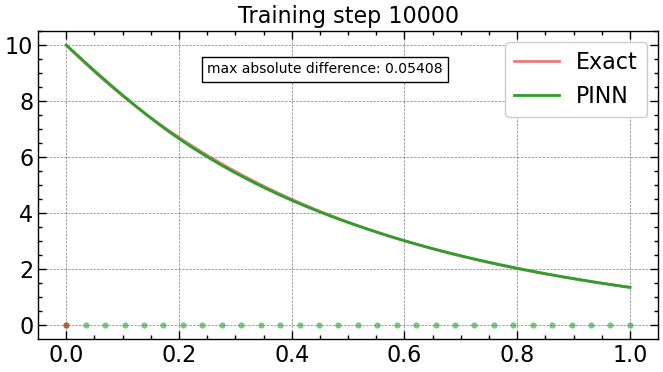

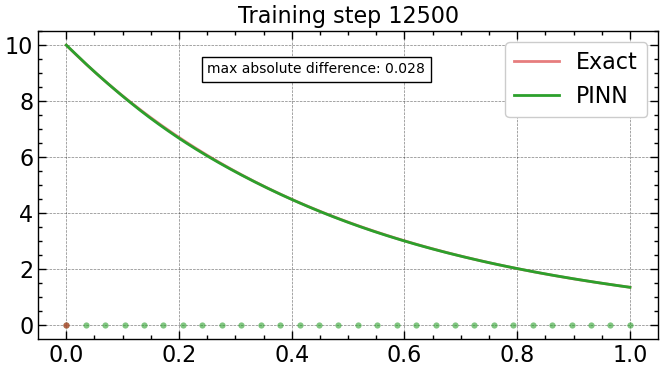

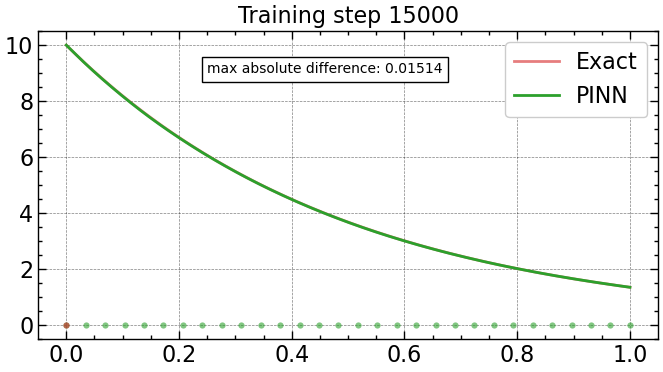

In [5]:
for i in range(num_iter):
    optimizer.zero_grad()

    g = model(t_boundary)
    loss1 = (torch.squeeze(g) - 10) ** 2

    g = model(t_physics)
    dgdt = torch.autograd.grad(g, t_physics, torch.ones_like(g), create_graph=True)[0]
    loss2 = torch.mean((dgdt + g * gamma) ** 2)
    lamda = 1e-4
    
    loss = loss1 + 1e-4 * loss2
    loss.backward()
    optimizer.step()

    if i % 2500 == 0:
        g = model(t_test).detach()
        diff = str(np.round(np.max(np.abs(g - g_exact).numpy()), 5))
        plt.figure(figsize=(8, 4))
        plt.scatter(t_physics.detach()[:, 0],
                    torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0],
                    torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], g_exact[:, 0], label="Exact", color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], g[:, 0], label="PINN", color="tab:green")
        plt.title(f"Training step {i}")
        plt.text(0.25, 9, f'max absolute difference: {diff}', size=10, bbox=dict(facecolor='white', edgecolor='black'))
        plt.legend()
        plt.show()

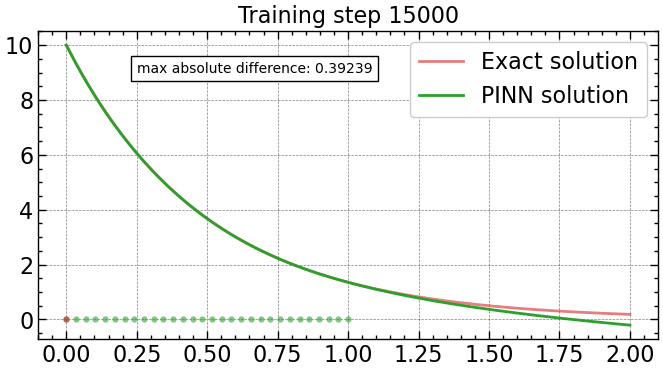

In [19]:
t_test = torch.linspace(0, 2, 600).view(-1, 1)
g_exact = g_analytic(t_test)
g = model(t_test).detach()
diff = str(np.round(np.max(np.abs(g - g_exact).numpy()), 5))
plt.figure(figsize=(8, 4))
plt.scatter(t_physics.detach()[:, 0],
            torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
plt.scatter(t_boundary.detach()[:, 0],
            torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
plt.plot(t_test[:, 0], g_exact[:, 0], label="Exact solution", color="tab:red", alpha=0.6)
plt.plot(t_test[:, 0], g[:, 0], label="PINN solution", color="tab:green")
plt.title(f"Training step {i}")
plt.text(0.25, 9, f'max absolute difference: {diff}', size=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.legend()
plt.show()

In [20]:
model = FCN(1, 1, 10, 3)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, 1, 300).view(-1, 1)
g0 = 10
gamma = 2
g_exact = g_analytic(t_test, gamma, g0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_iter = 15001

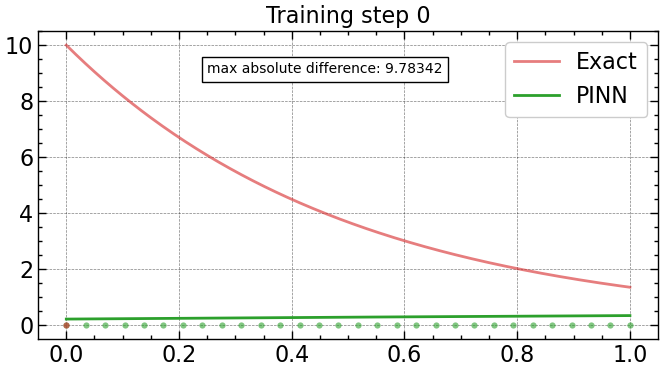

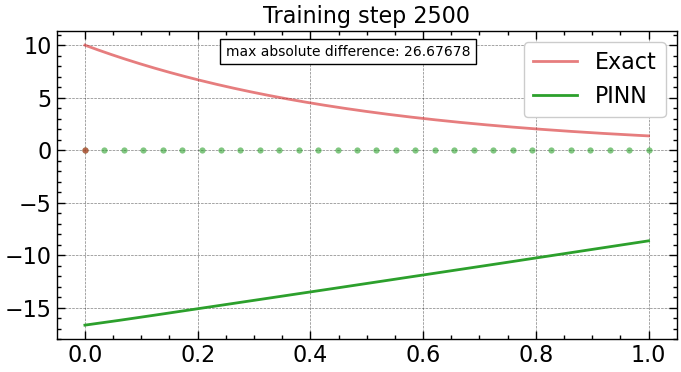

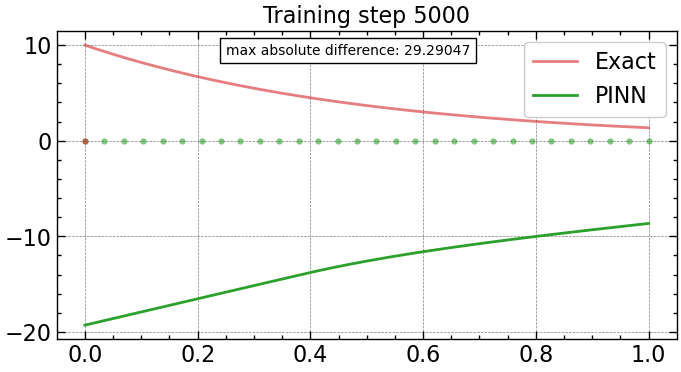

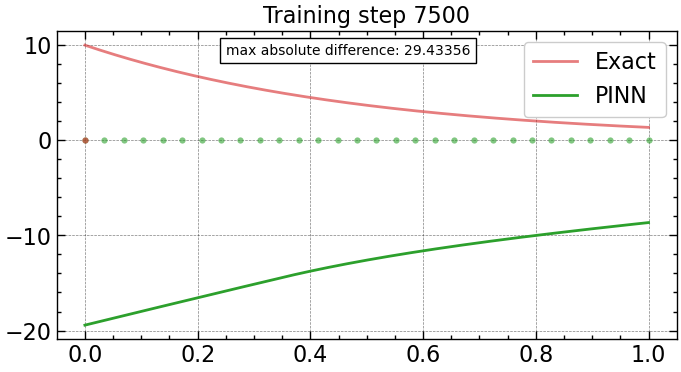

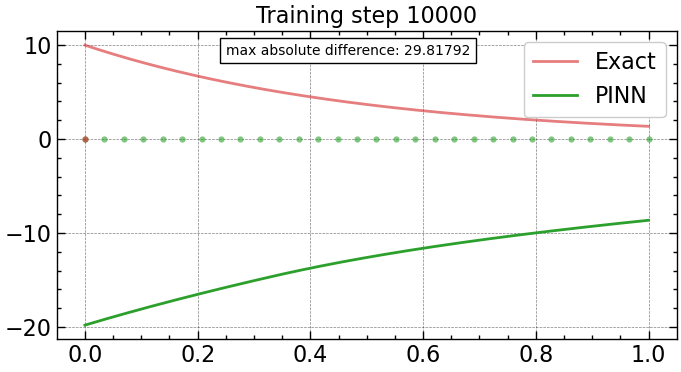

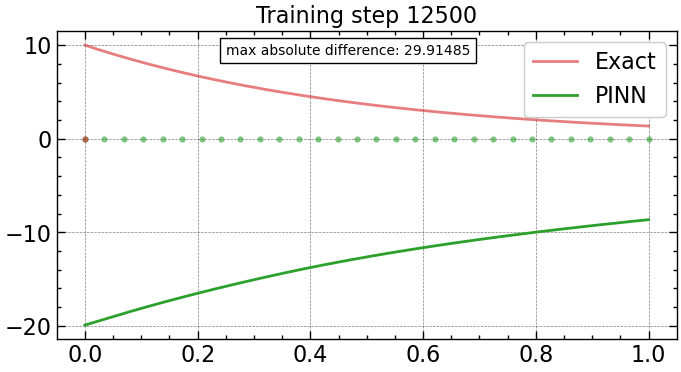

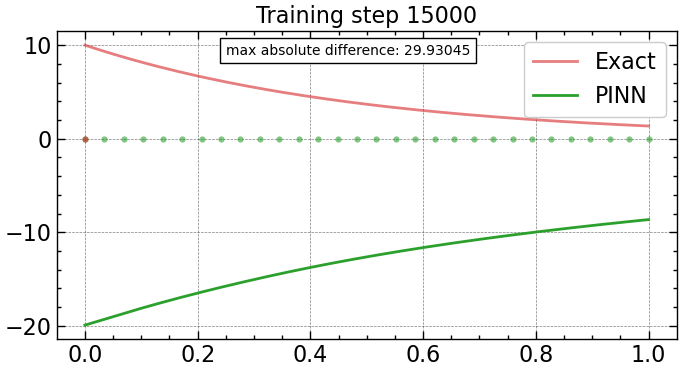

In [21]:
for i in range(num_iter):
    optimizer.zero_grad()

    g = g0 + t_physics * model(t_physics)
    dgdt = torch.autograd.grad(g, t_physics, torch.ones_like(g), create_graph=True)[0]
    loss = torch.mean((dgdt + g * gamma) ** 2)

    loss.backward()
    optimizer.step()

    if i % 2500 == 0:
        g = model(t_test).detach()
        diff = str(np.round(np.max(np.abs(g - g_exact).numpy()), 5))
        plt.figure(figsize=(8, 4))
        plt.scatter(t_physics.detach()[:, 0],
                    torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0],
                    torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], g_exact[:, 0], label="Exact", color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], g[:, 0], label="PINN", color="tab:green")
        plt.title(f"Training step {i}")
        plt.text(0.25, 9, f'max absolute difference: {diff}', size=10, bbox=dict(facecolor='white', edgecolor='black'))
        plt.legend()
        plt.show()